<a href="https://colab.research.google.com/github/Trung0Minh/AIO2023-MODULE-6/blob/main/transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer

## Architecture

In [1]:
import torch
import torch.nn as nn

In [2]:
class TokenAndPositionEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_dim, max_length, device='cpu'):
        super().__init__()
        self.device = device
        self.word_emb = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim
        )
        self.pos_emb = nn.Embedding(
            num_embeddings=max_length,
            embedding_dim=embed_dim
        )

    def forward(self, x):
        N, seq_len = x.size()
        positions = torch.arange(0, seq_len).expand(N, seq_len).to(self.device)
        output1 = self.word_emb(x)
        output2 = self.pos_emb(positions)
        return output1 + output2

In [3]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attention = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            batch_first=True
        )

        self.ffn = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=ff_dim),
            nn.ReLU(),
            nn.Linear(in_features=ff_dim, out_features=embed_dim)
        )

        self.layernorm_1 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.layernorm_2 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)

        self.dropout_1 = nn.Dropout(p=dropout)
        self.dropout_2 = nn.Dropout(p=dropout)

    def forward(self, query, key, value):
        attention_ouput, _ = self.attention(query, key, value)
        attention_ouput = self.dropout_1(attention_ouput)
        out_1 = self.layernorm_1(query + attention_ouput)
        ffn_output = self.ffn(out_1)
        ffn_output = self.dropout_2(ffn_output)
        out_2 = self.layernorm_2(out_1 + ffn_output)
        return out_2

In [4]:
class TransformerEncoder(nn.Module):
    def __init__(self, src_vocab_size, embed_dim, max_length, num_layers, num_heads, ff_dim, dropout=0.1, device='cpu'):
        super().__init__()
        self.embedding = TokenAndPositionEmbedding(
            vocab_size=src_vocab_size,
            embed_dim=embed_dim,
            max_length=max_length,
            device=device
        )

        self.layers = nn.ModuleList(
            [
                TransformerEncoderBlock(
                    embed_dim=embed_dim,
                    num_heads=num_heads,
                    ff_dim=ff_dim,
                    dropout=dropout
                ) for _ in range(num_layers)
            ]
        )

    def forward(self, x):
        output = self.embedding(x)
        for layer in self.layers:
            output = layer(output, output, output)
        return output

In [5]:
class TransformerDecoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attention = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            batch_first=True
        )

        self.cross_attn = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            batch_first=True
        )

        self.ffn = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=ff_dim),
            nn.ReLU(),
            nn.Linear(in_features=ff_dim, out_features=embed_dim)
        )

        self.layernorm_1 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.layernorm_2 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.layernorm_3 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)

        self.dropout_1 = nn.Dropout(p=dropout)
        self.dropout_2 = nn.Dropout(p=dropout)
        self.dropout_3 = nn.Dropout(p=dropout)

    def forward(self, x, enc_ouput, src_mask, tgt_mask):
        attn_output, _ = self.attention(x, x, x, attn_mask=tgt_mask)
        attn_output = self.dropout_1(attn_output)
        out_1 = self.layernorm_1(attn_output + x)

        attn_output, _ = self.cross_attn(
            out_1, enc_ouput, enc_ouput, attn_mask=src_mask
        )
        attn_output = self.dropout_2(attn_output)
        out_2 = self.layernorm_2(attn_output + out_1)

        ffn_output = self.ffn(out_2)
        ffn_output = self.dropout_3(ffn_output)
        out_3 = self.layernorm_3(ffn_output + out_2)
        return out_3

In [6]:
class TransformerDecoder(nn.Module):
    def __init__(self, tgt_vocab_size, embed_dim, max_length, num_layers, num_heads, ff_dim, dropout=0.1, device='cpu'):
        super().__init__()
        self.embedding = TokenAndPositionEmbedding(
            vocab_size=tgt_vocab_size,
            embed_dim=embed_dim,
            max_length=max_length,
            device=device
        )
        self.layers = nn.ModuleList(
            [
                TransformerDecoderBlock(
                    embed_dim, num_heads, ff_dim, dropout
                ) for _ in range(num_layers)
            ]
        )

    def forward(self, x, enc_output, src_mask, tgt_mask):
        output = self.embedding(x)
        for layer in self.layers:
            output = layer(output, enc_output, src_mask, tgt_mask)
        return output

In [7]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, embed_dim, max_length, num_layers, num_heads, ff_dim, dropout=0.1, device='cpu'):
        super().__init__()
        self.device = device
        self.encoder = TransformerEncoder(
            src_vocab_size, embed_dim, max_length, num_layers, num_heads, ff_dim
        )

        self.decoder = TransformerDecoder(
            tgt_vocab_size, embed_dim, max_length, num_layers, num_heads, ff_dim
        )

        self.fc = nn.Linear(embed_dim, tgt_vocab_size)

    def generate_mask(self, src, tgt):
        src_seq_len = src.shape[1]
        tgt_seq_len = tgt.shape[1]

        src_mask = torch.zeros(
            (src_seq_len, src_seq_len),
            device=self.device
        ).type(torch.bool)

        tgt_mask = torch.tril(
            torch.ones(
                (tgt_seq_len, tgt_seq_len),
                device=self.device
            ) == 1
        ).transpose(0, 1)

        tgt_mask = tgt_mask.float().masked_fill(tgt_mask == 0, float('-inf')).masked_fill(tgt_mask == 1, float(0.0))
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        enc_output = self.encoder(src)
        dec_output = self.decoder(tgt, enc_output, src_mask, tgt_mask)
        output = self.fc(dec_output)
        return output

In [8]:
batch_size = 128
src_vocab_size = 1000
tgt_vocab_size = 2000
embed_dim = 200
max_length = 100
num_layers = 2
num_heads = 4
ff_dim = 256

model = Transformer(
    src_vocab_size, tgt_vocab_size,
    embed_dim, max_length, num_layers, num_heads, ff_dim
)

src = torch.randint(
    high=2,
    size=(batch_size, max_length),
    dtype=torch.int64
)

tgt = torch.randint(
    high=2,
    size=(batch_size, max_length),
    dtype=torch.int64
)

prediction = model(src, tgt)
prediction.shape # batch_size x max_length x tgt_vocab_size
prediction

tensor([[[ 0.2568,  0.0472,  0.4590,  ..., -0.0378,  0.9747, -0.0209],
         [-0.3638,  1.3509, -0.2871,  ...,  0.3441,  0.3855,  0.5903],
         [ 0.6097,  0.3322, -0.0389,  ..., -0.2848,  0.9938,  0.6144],
         ...,
         [-0.4790,  0.4101,  0.4130,  ...,  0.0069, -0.0998, -0.6116],
         [-0.1463,  0.4269, -0.0814,  ..., -0.4260,  0.7476, -0.0676],
         [-0.5131,  0.7542, -0.0360,  ..., -0.5289,  0.7667, -0.3583]],

        [[ 0.3828,  0.3560,  0.2069,  ...,  0.0746,  1.0731,  0.2413],
         [-0.2141,  1.1734, -0.2356,  ...,  0.3453,  0.1083,  0.5307],
         [ 0.1093,  0.2205, -0.1639,  ...,  0.1413,  1.1326,  0.4816],
         ...,
         [ 0.1298,  0.3500,  0.5230,  ..., -0.2366,  0.1773, -0.1341],
         [ 0.1462,  0.1200, -0.3462,  ..., -0.5185,  0.8017, -0.2854],
         [-0.4386,  0.3506, -0.1873,  ..., -0.1177,  0.4925, -0.8679]],

        [[ 0.2152, -0.1363,  0.0795,  ...,  0.1824,  0.7375,  0.0155],
         [-0.3116,  1.1542, -0.3985,  ...,  0

## Text Classification

In [9]:
!git clone https://github.com/congnghia0609/ntc-scv.git

Cloning into 'ntc-scv'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 39 (delta 0), reused 4 (delta 0), pack-reused 35 (from 1)
Receiving objects: 100% (39/39), 186.94 MiB | 16.29 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [ ]:
!unzip ./ntc-scv/data/data_test.zip -d ./data
!unzip ./ntc-scv/data/data_train.zip -d ./data
!rm -rf ntc-scv/

In [11]:
import os
import pandas as pd

def load_data_from_path(folder_path):
    examples = []
    for label in os.listdir(folder_path):
        full_path = os.path.join(folder_path, label)
        for filename in os.listdir(full_path):
            file_path = os.path.join(full_path, filename)
            with open(file_path, "r") as f:
                lines = f.readlines()
            sentence = " ".join(lines)
            if label == "neg":
                label = 0
            elif label == "pos":
                label = 1
            data = {
                "sentence": sentence,
                "label": label
            }
            examples.append(data)
    return pd.DataFrame(examples)

In [12]:
folder_paths = {
    'train': './data/data_train/train',
    'valid': './data/data_train/test',
    'test': './data/data_test/test'
}

train_df = load_data_from_path(folder_paths['train'])
valid_df = load_data_from_path(folder_paths['valid'])
test_df = load_data_from_path(folder_paths['test'])

In [13]:
import re
import string

def preprocess_text(text):
    # remove URLs https://www.
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text = url_pattern.sub(r' ', text)

    # remove HTML Tags: <...>
    html_pattern = re.compile(r'<[^>]+>')
    text = html_pattern.sub(r' ', text)

    # remove puncs and digits
    replace_chars = list(string.punctuation + string.digits)
    for char in replace_chars:
        text = text.replace(char, ' ')

    # remove emoji
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r' ', text)

    # normalize whitespace
    text = ' '.join(text.split())

    # lowercasing
    text = text.lower()

    return text

In [14]:
train_df['sentence'] = [preprocess_text(row['sentence']) for index, row in train_df.iterrows()]
valid_df['sentence'] = [preprocess_text(row['sentence']) for index, row in valid_df.iterrows()]
test_df['sentence'] = [preprocess_text(row['sentence']) for index, row in test_df.iterrows()]

In [ ]:
!pip install torchtext

In [ ]:
def yield_tokens(sentences, tokenizer):
    for sentence in sentences:
        yield tokenizer(sentence)

# word-based tokenizer
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer("basic_english")

# build vocabulary
from torchtext.vocab import build_vocab_from_iterator
vocab_size = 10000
vocabulary = build_vocab_from_iterator(
    yield_tokens(train_df['preprocess_sentence'], tokenizer),
    max_tokens=vocab_size,
    specials=["<pad>", "<unk>"]
)
vocabulary.set_default_index(vocabulary["<unk>"])

# convert torchtext dataset
from torchtext.data.functional import to_map_style_dataset

def prepare_dataset(df):
    # create iterator for dataset: (sentence, label)
    for index, row in df.iterrows():
        sentence = row['preprocess_sentence']
        encoded_sentence = vocabulary(tokenizer(sentence))
        label = row['label']
        yield encoded_sentence, label

train_dataset = prepare_dataset(train_df)
train_dataset = to_map_style_dataset(train_dataset)

valid_dataset = prepare_dataset(valid_df)
valid_dataset = to_map_style_dataset(valid_dataset)

test_dataset = prepare_dataset(test_df)
test_dataset = to_map_style_dataset(test_dataset)

In [ ]:
import torch

seq_length = 100

def collate_batch(batch):
    # create inputs, offsets, labels for batch
    sentences, labels = list(zip(*batch))
    9

    encoded_sentences = [
        sentence + ([0] * (seq_length - len(sentence))) if len(sentence) < seq_length else
        sentence[:seq_length]
        for sentence in sentences
    ]

    encoded_sentences = torch.tensor(encoded_sentences, dtype=torch.int64)
    labels = torch.tensor(labels)

    return encoded_sentences, labels

from torch.utils.data import DataLoader

batch_size = 128

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

In [1]:
import time

def train_epoch(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        predictions = model(inputs)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()

        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)

        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                '| accuracy {:8.3f}'.format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                ))

    start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

# evaluate
def evaluate_epoch(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)

            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [2]:
def train(model, model_name, save_model, optimizer, criterion, train_dataloader,
          valid_dataloader, num_epochs, device):
    train_accs, train_losses = [], []
    eval_accs, eval_losses = [], []
    best_loss_eval = 100
    times = []

    for epoch in range(1, num_epochs + 1):
        epoch_start_time = time.time()
        # Training
        train_acc, train_loss = train_epoch(model, optimizer, criterion,
                                           train_dataloader, device, epoch)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        # Evaluation
        eval_acc, eval_loss = evaluate_epoch(model, criterion, valid_dataloader, device)
        eval_accs.append(eval_acc)
        eval_losses.append(eval_loss)

        # Save best model
        if eval_loss < best_loss_eval:
            torch.save(model.state_dict(), save_model + f'/{model_name}.pt')

        times.append(time.time() - epoch_start_time)

        # Print loss, acc end epoch
        print("-" * 59)
        print(
            "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
            "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
                epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
            )
        )

        print("-" * 59)

    # Load best model
    model.load_state_dict(torch.load(save_model + f'/{model_name}.pt'))

    model.eval()

    metrics = {
        'train_accuracy': train_accs,
        'train_loss': train_losses,
        'valid_accuracy': eval_accs,
        'valid_loss': eval_losses,
        'time': times
    }

    return model, metrics

In [3]:
import matplotlib.pyplot as plt

def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    axs[0].plot(epochs, train_accs, label="Training")
    axs[0].plot(epochs, eval_accs, label="Evaluation")
    axs[1].plot(epochs, train_losses, label="Training")
    axs[1].plot(epochs, eval_losses, label="Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

In [ ]:
class TransformerEncoderCls(nn.Module):
    def __init__(self, vocab_size, max_length, num_layers, embed_dim, num_heads, ff_dim, dropout=0.1, device='cpu'):
        super().__init__()
        self.encoder = TransformerEncoder(
            vocab_size, embed_dim, max_length, num_layers, num_heads, ff_dim, dropout, device
        )
        self.pooling = nn.AvgPool1d(kernel_size=max_length)
        self.fc1 = nn.Linear(embed_dim, 20)
        self.fc2 = nn.Linear(20, 2)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        output = self.encoder(x)
        output = self.pooling(output.permute(0, 2, 1)).squeeze()
        output = self.fc1(output)
        output = self.relu(output)
        output = self.dropout(output)
        output = self.fc2(output)
        return output

In [ ]:
import torch.optim as optim

vocab_size = 10000
max_length = 100
embed_dim = 200
num_layers = 2
num_heads = 4
ff_dim = 128
dropout = 0.1

model = TransformerEncoderCls(
    vocab_size, max_length, num_layers, embed_dim, num_heads, ff_dim, dropout
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TransformerEncoderCls(
    vocab_size, max_length, num_layers, embed_dim, num_heads, ff_dim, dropout, device
)

model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

num_epochs = 50
save_model = './model'
os.makedirs(save_model, exist_ok=True)
model_name = 'model'

model, metrics = train(
    model, model_name, save_model, optimizer, criterion, train_dataloader,
    valid_dataloader, num_epochs, device
)

In [ ]:
plot_result(num_epochs, metrics['train_accuracy'], metrics['valid_accuracy'],
            metrics['train_loss'], metrics['valid_loss'])

# Text Classification using BERT

In [17]:
!git clone https://github.com/congnghia0609/ntc-scv.git

Cloning into 'ntc-scv'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 39 (delta 0), reused 4 (delta 0), pack-reused 35 (from 1)
Receiving objects: 100% (39/39), 186.94 MiB | 12.68 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [ ]:
!unzip ./ntc-scv/data/data_test.zip -d ./data
!unzip ./ntc-scv/data/data_train.zip -d ./data
!rm -rf ntc-scv/

In [19]:
import os
import pandas as pd

def load_data_from_path(folder_path):
    examples = []
    for label in os.listdir(folder_path):
        full_path = os.path.join(folder_path, label)
        for filename in os.listdir(full_path):
            file_path = os.path.join(full_path, filename)
            with open(file_path, "r") as f:
                lines = f.readlines()
            sentence = " ".join(lines)
            if label == "neg":
                label = 0
            elif label == "pos":
                label = 1
            data = {
                "sentence": sentence,
                "label": label
            }
            examples.append(data)
    return pd.DataFrame(examples)

In [20]:
folder_paths = {
    'train': './data/data_train/train',
    'valid': './data/data_train/test',
    'test': './data/data_test/test'
}

train_df = load_data_from_path(folder_paths['train'])
valid_df = load_data_from_path(folder_paths['valid'])
test_df = load_data_from_path(folder_paths['test'])

In [ ]:
!pip install datasets

In [22]:
from datasets import Dataset, DatasetDict

raw_dataset = DatasetDict({
    'train': Dataset.from_pandas(train_df),
    'valid': Dataset.from_pandas(valid_df),
    'test': Dataset.from_pandas(test_df)
})

In [23]:
import re
import string

def preprocess_text(text):
    # remove URLs https://www.
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text = url_pattern.sub(r' ', text)

    # remove HTML Tags: <...>
    html_pattern = re.compile(r'<[^>]+>')
    text = html_pattern.sub(r' ', text)

    # remove puncs and digits
    replace_chars = list(string.punctuation + string.digits)
    for char in replace_chars:
        text = text.replace(char, ' ')

    # remove emoji
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r' ', text)

    # normalize whitespace
    text = ' '.join(text.split())

    # lowercasing
    text = text.lower()

    return text

In [24]:
train_df['sentence'] = [preprocess_text(row['sentence']) for index, row in train_df.iterrows()]
valid_df['sentence'] = [preprocess_text(row['sentence']) for index, row in valid_df.iterrows()]
test_df['sentence'] = [preprocess_text(row['sentence']) for index, row in test_df.iterrows()]

In [25]:
from transformers import AutoTokenizer

model_name = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    use_fast=True
)

max_seq_length = 100
max_seq_length = min(max_seq_length, tokenizer.model_max_length)

def preprocess_function(examples):
    result = tokenizer(
        examples['sentence'],
        padding="max_length",
        max_length=max_seq_length,
        truncation=True
    )
    result['label'] = examples['label']
    return result

processed_dataset = raw_dataset.map(
    preprocess_function,
    batched=True,
    desc="Running tokenizer on dataset"
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Running tokenizer on dataset:   0%|          | 0/30000 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [26]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [27]:
from transformers import AutoConfig, AutoModelForSequenceClassification

num_labels = 2

config = AutoConfig.from_pretrained(
    model_name,
    num_labels=num_labels,
    finetuning_task="text-classification"
)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    config=config
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip install evaluate

In [29]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    result = metric.compute(predictions=predictions, references=labels)
    return result

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="save_model",
    learning_rate=2e-5,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    num_train_epochs=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["valid"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator
)

trainer.train()

# Vision Transformer

In [4]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch import nn

import math
import os

In [5]:
!gdown 11Buzytn4vIh4x_Oqz8MY29JMMdIqSzj-

Downloading...
From (original): https://drive.google.com/uc?id=11Buzytn4vIh4x_Oqz8MY29JMMdIqSzj-
From (redirected): https://drive.google.com/uc?id=11Buzytn4vIh4x_Oqz8MY29JMMdIqSzj-&confirm=t&uuid=4ecbedde-18fa-4e70-adfe-dafe42eacddb
To: /content/flower_photos.zip
100% 230M/230M [00:03<00:00, 60.4MB/s]


In [ ]:
!unzip ./flower_photos.zip

In [7]:
data_patch = "./flower_photos"
dataset = ImageFolder(root=data_patch)
num_samples = len(dataset)
classes = dataset.classes
num_classes = len(classes)

TRAIN_RATIO, VALID_RATIO = 0.8, 0.1
n_train_examples = int(TRAIN_RATIO * num_samples)
n_valid_examples = int(VALID_RATIO * num_samples)
n_test_examples = num_samples - n_train_examples - n_valid_examples

train_dataset, valid_dataset, test_dataset = random_split(
    dataset, [n_train_examples, n_valid_examples, n_test_examples]
)

In [8]:
dataset

Dataset ImageFolder
    Number of datapoints: 3670
    Root location: ./flower_photos

In [9]:
IMG_SIZE = 224

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_dataset.dataset.transform = train_transforms
valid_dataset.dataset.transform = test_transforms
test_dataset.dataset.transform = test_transforms

In [10]:
BATCH_SIZE = 4

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [11]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attention = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            batch_first=True
        )

        self.ffn = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=ff_dim),
            nn.ReLU(),
            nn.Linear(in_features=ff_dim, out_features=embed_dim)
        )

        self.layernorm = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value):
        attention_ouput, _ = self.attention(query, key, value)
        attention_ouput = self.dropout(attention_ouput)
        out_1 = self.layernorm(query + attention_ouput)
        ffn_output = self.ffn(out_1)
        ffn_output = self.dropout(ffn_output)
        out_2 = self.layernorm(out_1 + ffn_output)
        return out_2

In [12]:
class PatchPositionEmbedding(nn.Module):
    def __init__(self, image_size=224, embed_dim=512, patch_size=16, device='cpu'):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=3, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size, bias=False)
        scale = 1/(embed_dim ** 0.5)
        self.positional_embedding = nn.Parameter(
            scale*torch.randn((image_size // patch_size )**2, embed_dim)
        )
        self.device = device

    def forward(self, x):
        x = self.conv(x)
        x = x.reshape(x.shape[0], x.shape[1], -1)
        x = x.permute(0, 2, 1)

        x = x + self.positional_embedding.to(self.device)
        return x

In [13]:
class VisionTransformerCls(nn.Module):
    def __init__(self, image_size, embed_dim, num_heads, ff_dim, dropout=0.1, device='cpu', num_classes=10, patch_size=16):
        super().__init__()
        self.embed_layer = PatchPositionEmbedding(image_size, embed_dim, patch_size, device)
        self.encoder = TransformerEncoder(embed_dim, num_heads, ff_dim, dropout)

        self.fc1 = nn.Linear(embed_dim, 20)
        self.fc2 = nn.Linear(20, num_classes)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.embed_layer(x)
        x = self.encoder(x, x ,x)
        x = x[:, 0, :]
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [14]:
image_size = 224
embed_dim = 512
num_heads = 4
ff_dim = 128
dropout = 0.1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VisionTransformerCls(
    image_size=image_size, embed_dim=embed_dim, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout,
    num_classes=num_classes, device=device
)

model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

num_epochs = 50
save_model = './vit_flowers'
os.makedirs(save_model, exist_ok=True)
model_name = 'vit_flowers'

model, metrics = train(
    model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader,
    num_epochs, device
)

| epoch   1 |    50/  734 batches | accuracy    0.299
| epoch   1 |   100/  734 batches | accuracy    0.295
| epoch   1 |   150/  734 batches | accuracy    0.320
| epoch   1 |   200/  734 batches | accuracy    0.327
| epoch   1 |   250/  734 batches | accuracy    0.324
| epoch   1 |   300/  734 batches | accuracy    0.331
| epoch   1 |   350/  734 batches | accuracy    0.344
| epoch   1 |   400/  734 batches | accuracy    0.350
| epoch   1 |   450/  734 batches | accuracy    0.361
| epoch   1 |   500/  734 batches | accuracy    0.369
| epoch   1 |   550/  734 batches | accuracy    0.381
| epoch   1 |   600/  734 batches | accuracy    0.385
| epoch   1 |   650/  734 batches | accuracy    0.388
| epoch   1 |   700/  734 batches | accuracy    0.385
-----------------------------------------------------------
| End of epoch   1 | Time: 21.65s | Train Accuracy    0.386 | Train Loss    1.410 | Valid Accuracy    0.450 | Valid Loss    1.262 
-----------------------------------------------------

<ipython-input-2-f7bf9db6a7dc>:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_model + f'/{model_name}.pt'))


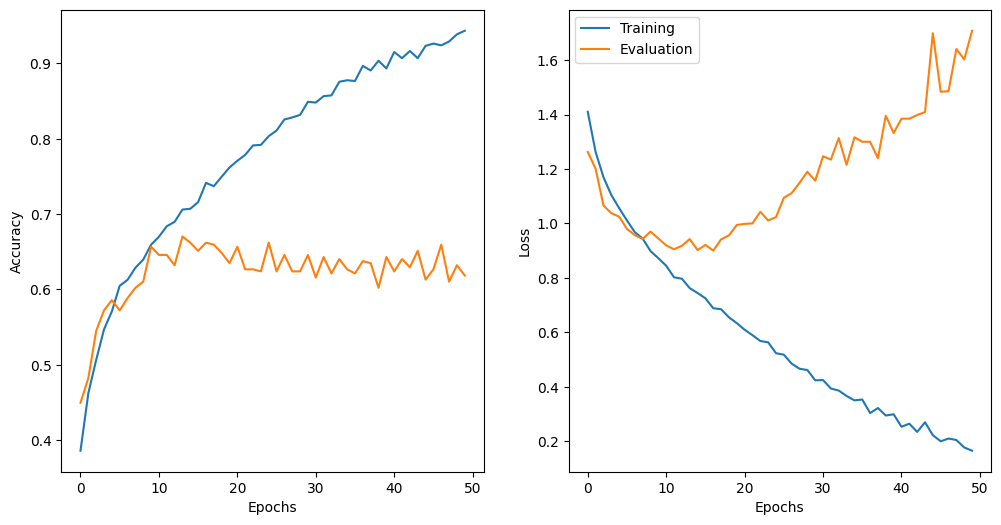

In [15]:
plot_result(num_epochs, metrics['train_accuracy'], metrics['valid_accuracy'],
            metrics['train_loss'], metrics['valid_loss'])

In [16]:
from transformers import ViTForImageClassification

id2label = {id: label for id, label in enumerate(classes)}
label2id = {label: id for id, label in id2label.items()}

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                 num_labels=num_classes,
                                                 id2label=id2label,
                                                 label2id=label2id)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [ ]:
!pip install evaluate

In [21]:
import evaluate
import numpy as np

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [23]:
import torch
from transformers import ViTImageProcessor
from transformers import TrainingArguments, Trainer

feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

metric_name = "accuracy"

args = TrainingArguments(
    f"vit_flowers",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

def collate_fn(examples):
    # example => Tuple(image, label)
    pixel_values = torch.stack([example[0] for example in examples])
    labels = torch.tensor([example[1] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-23-b0f6d7f09c22>:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()
outputs = trainer.predict(test_dataset)
outputs.metrics